In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from HullWhite import HullWhite
import random
from scipy.optimize import fsolve
beta = np.array([1.879892, 0.579211, 	3.993992, 1.445091])
tau  = np.array([ 16.633491, 	0.319680])
reversion=0.08670264780833303, #0.13949636660880768 
volatility=0.013928489964789946 #0.017793899652989272
HW = HullWhite(initial=0.02459103, reversion=0.03, volatility=0.00200, b=beta, tau=tau)

 

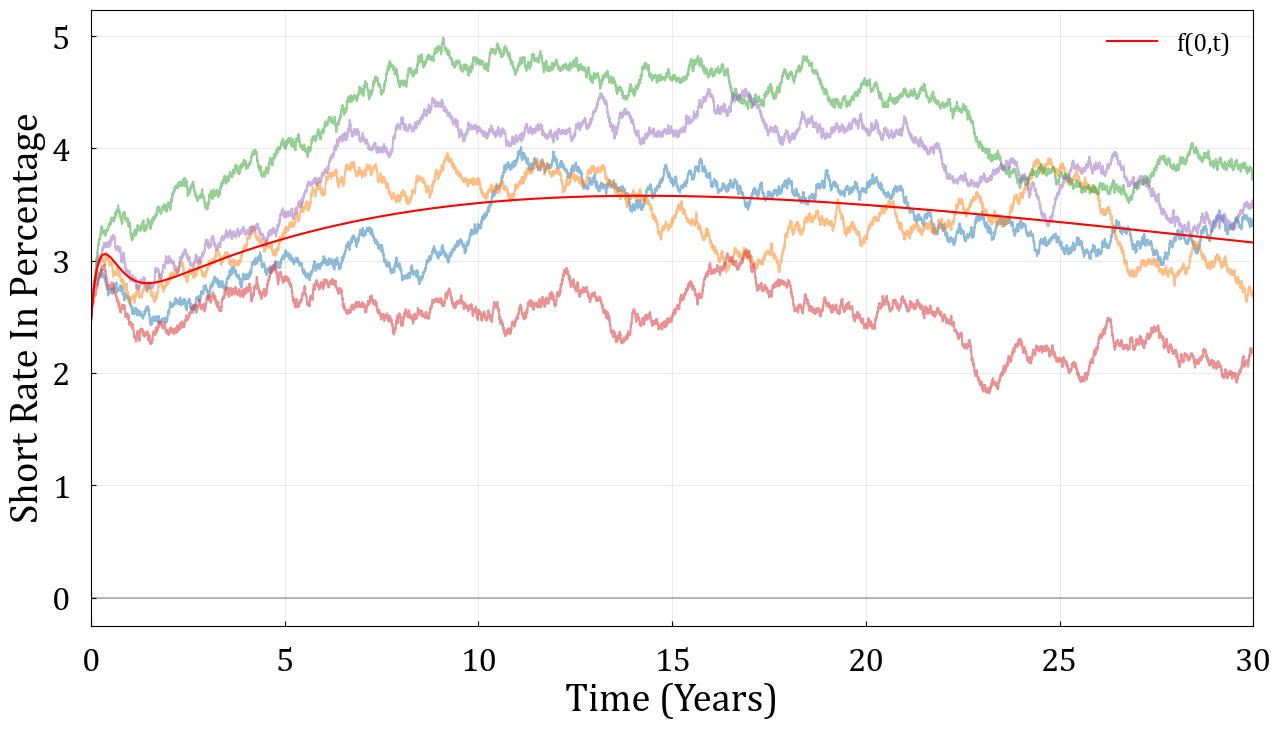

In [2]:
plt.rc('font',family='Cambria')
fig, ax = plt.subplots()
for i in range(5):
    np.random.seed(i)
    time, float = HW.create_path(1/365,30)
    sns.lineplot(x=time, y=float*100, alpha=0.5)
sns.lineplot(x=time, y=[HW.forwardCurve(t, beta, tau)*100 for t in time], color='red', label='f(0,t)')   

fig.set_size_inches(15,8)

ax.set_xlabel('Time (Years)', fontname="Cambria", fontsize = 28)
ax.set_ylabel('Short Rate In Percentage', fontname="Cambria", fontsize = 28)
ax.tick_params(axis='x', direction='in', right = 'True', labelsize = 24, pad = 15)
ax.tick_params(axis='y', direction='in', top = 'True', labelsize = 24, pad = 15)
ax.axhline(y=0, color='k', alpha = 0.25)
ax.set_xlim(0,30)
plt.grid(alpha = 0.25)
plt.xticks(np.arange(0, 35, 5))
plt.legend(frameon = False, fontsize = 18, loc='upper right')
plt.savefig('./Graphs/SimPathExample.png', bbox_inches='tight')

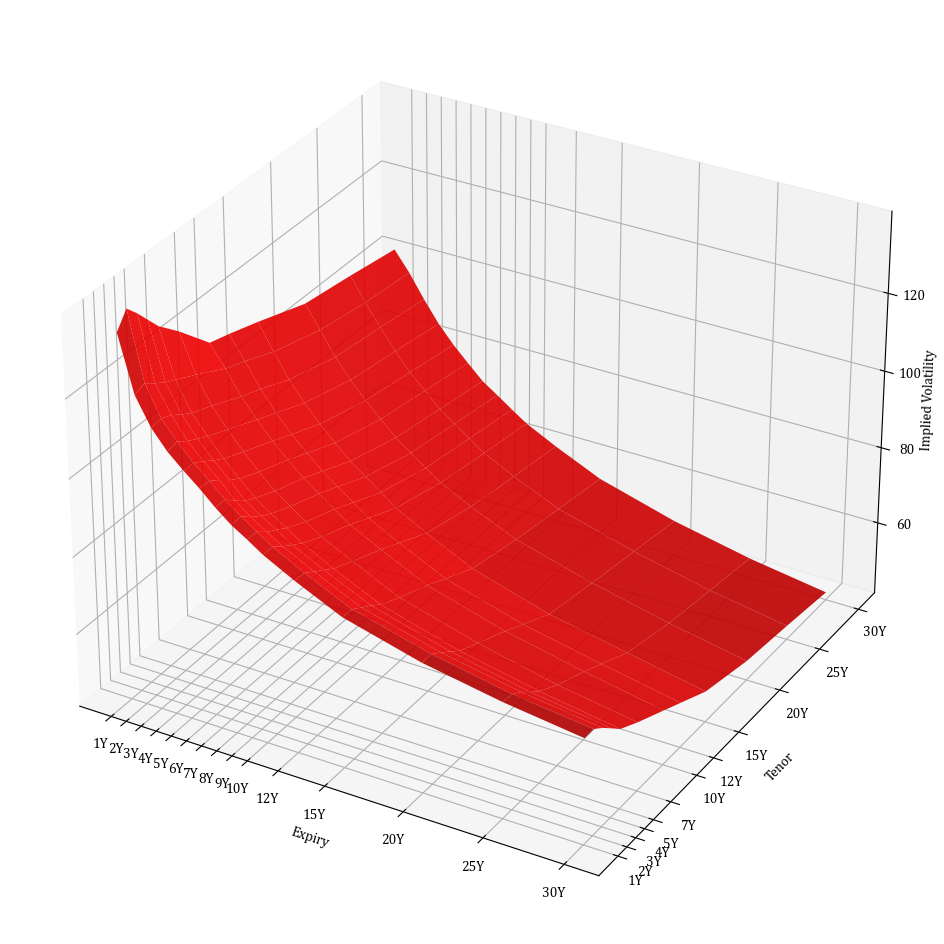

In [3]:
import pandas as pd

file_path   = 'bvolmatrix.xlsx'
sheet       = 'STRADDLE'
sheetf      = 'STRIKE'
sheeti      = 'BVOL'
df          = pd.read_excel(file_path, sheet_name=sheet,header=None)
dff         = pd.read_excel(file_path, sheet_name=sheetf,header=None)
dfi         = pd.read_excel(file_path, sheet_name=sheeti,header=None)
straddlesobs       = pd.DataFrame(df[[x for x in np.arange(4,16)]][3:22])
strikes            = pd.DataFrame(dff[[x for x in np.arange(4,16)]][3:22])
impliedVol         = pd.DataFrame(dfi[[x for x in np.arange(4,16)]][3:22])
straddlesobs.index     = df[1][3:22].values
strikes.index          = dff[1][3:22].values
impliedVol.index       = dfi[1][3:22].values
straddlesobs.index.name='Expiry'
strikes.index.name     ='Expiry'
impliedVol.index.name  ='Expiry' 
straddlesobs.columns   = [int(x) for x in df.iloc[1][4:16].values]
strikes.columns        = [int(x) for x in dff.iloc[1][4:16].values]
impliedVol.columns     = [int(x) for x in dfi.iloc[1][4:16].values]
# straddlesobs
sheeta      = 'ARTICLE'
dfff        = pd.read_excel(file_path, sheet_name=sheeta,header=None)
articleobs  = dfff[[x for x in np.arange(4,17)]][3:17]/10000
articleobs.index = dfff[1][3:17].values
articleobs.index.name = 'Expiry'
articleobs.columns = [int(x) for x in dfff.iloc[1][4:17].values]

straddlesobs=straddlesobs.iloc[4::,0::]
strikes = strikes.iloc[4::,0::]
impliedVol = impliedVol.iloc[4::,0::]

def monthoryear(x):
    if x<12:
        return f'{int(x)}M'
    else:
        return f'{int(x/12)}Y'
    

# X,Y = np.meshgrid(straddlesobs.columns/12, straddlesobs.index/12)
# fig = plt.figure(figsize=(16,16))
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(Y,X,straddlesobs.values)
# ax.set_xlabel('Expiry')
# ax.set_xticks((straddlesobs.index/12))
# ax.set_xticklabels([monthoryear(x) for x in straddlesobs.index])
# ax.set_ylabel('Tenor')
# ax.set_yticklabels([f'{int(x/12)}Y' for x in straddlesobs.columns])
# ax.set_yticks(straddlesobs.columns/12)
# ax.invert_xaxis()
# plt.show()

# fig = plt.figure(figsize=(8,8))
# X,Y = np.meshgrid(impliedVol.columns/12, impliedVol.index/12)
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(Y,X,impliedVol.values, alpha=0.9, color='red')

# ax.set_xlabel('Expiry')
# ax.set_xticks((straddlesobs.index/12))
# ax.set_xticklabels([monthoryear(x) for x in straddlesobs.index])
# ax.set_ylabel('Tenor')
# ax.set_yticks(straddlesobs.columns/12)
# ax.set_yticklabels([f'{int(x/12)}Y' for x in straddlesobs.columns])
# ax.invert_xaxis()
# plt.show()

fig = plt.figure(figsize=(12,12))
X,Y = np.meshgrid(impliedVol.columns/12, impliedVol.index/12)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Y,X,impliedVol.values, alpha=0.9, color='red')
ax.set_xlabel('Expiry')
ax.set_xticks((straddlesobs.index/12))
ax.set_xticklabels([monthoryear(x) for x in straddlesobs.index])
ax.set_ylabel('Tenor')
ax.set_zlabel('Implied Volatility')
ax.zaxis.labelpad=-0.7
ax.set_yticks(straddlesobs.columns/12)
ax.set_yticklabels([f'{int(x/12)}Y' for x in straddlesobs.columns])

plt.show()

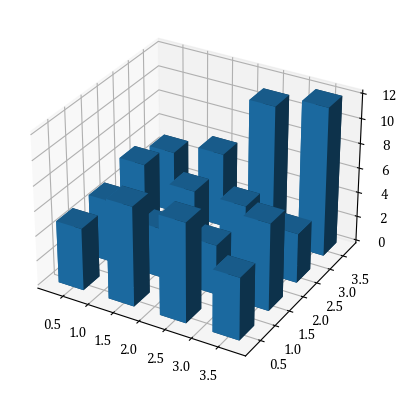

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
x, y = np.random.rand(2, 100) * 4
hist, xedges, yedges = np.histogram2d(x, y, bins=4, range=[[0, 4], [0, 4]])

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

plt.show()

In [6]:
from scipy.optimize import minimize, basinhopping, fsolve
def HullWhiteOptimizer(reversion,volatility, observedP, observedK):
    if volatility <= 0:
        print('Volatility is negative')
        return 100000, 100000
    straddleModel = observedP.copy()
    optHW = HullWhite(initial=0.02748672, 
                      reversion=reversion,
                      b = np.array([1.879892, 0.579211, 	3.993992, 1.445091]),
                      tau  = np.array([ 16.633491, 	0.319680]),
                      volatility=volatility)
    for expiry in observedP.index:
        # Expiry first
        # Getting the right expiry and converting to years
        
        for tenor in observedP.columns:
            # Creating tenor legs
            T = np.arange(expiry/12, expiry/12+tenor/12+0.5, 0.5)
            S = np.arange(expiry/12, expiry/12+tenor/12+1)
            # Finding the ATM fixed rate
            K = observedK[tenor].loc[expiry]/100
            # K = fsolve(lambda x: optHW.swap(0, S, T, x), x0=MarketATM)[0]

            #Calculating the payer and receiver swpt price
            p = optHW.swaption(0,Te=expiry/12, S=S,T=T, K=K, payer=True)
            r = optHW.swaption(0,Te=expiry/12, S=S, T=T, K=K, payer=False)
            
            #Normalizing w.r.t. to the A(t,S) function (2.10) everythin you wanna know...
            A = np.array([optHW.marketZCB(Si) for Si in S[1::]]).sum()

            straddleModel[tenor].loc[expiry] = (p+r)/A
            # if (p+r)*10000<0:
            # print(p,r,expiry,tenor,reversion,volatility)
            

    error = ((straddleModel/observedP-1)**2).sum().sum()
    # print(f'{error}', end='                                                         \r')
    return error,straddleModel

In [87]:
Nfeval = 0
def callback(xk):
    global Nfeval
    print(f'Eval: {Nfeval}, x={(xk[0],xk[1])}, func: {HullWhiteOptimizer(xk[0], xk[1], observedP=straddlesobs, observedK=strikes)[0]}')
    Nfeval += 1
    return True
# callback([0.027832947, 0.11874695, 0.019677])

result = minimize(
    fun = lambda x: HullWhiteOptimizer(reversion=x[0], volatility=x[1], observedP=straddlesobs, observedK=strikes)[0],
    x0  = np.array([0.08670264780833303 ,0.013928489964789946]),
    # bounds = [(0.1,20),(1e-04,0.5), (1e-04, 0.1)],
    method='nelder-mead',
    tol = 1e-4,
    callback=callback
)

Eval: 0, x=(0.08670264780833303, 0.013928489964789946), func: 0.9272616007682889
Eval: 1, x=(0.08670264780833303, 0.013928489964789946), func: 0.9272616007682889
Eval: 2, x=(0.08670264780833303, 0.013928489964789946), func: 0.9272616007682889
Eval: 3, x=(0.08670264780833303, 0.013928489964789946), func: 0.9272616007682889
Eval: 4, x=(0.08670264780833303, 0.013928489964789946), func: 0.9272616007682889
Eval: 5, x=(0.08670264780833303, 0.013928489964789946), func: 0.9272616007682889
Eval: 6, x=(0.08670264780833303, 0.013928489964789946), func: 0.9272616007682889
Eval: 7, x=(0.08670264780833303, 0.013928489964789946), func: 0.9272616007682889
Eval: 8, x=(0.08670264780833303, 0.013928489964789946), func: 0.9272616007682889
Eval: 9, x=(0.08670264780833303, 0.013928489964789946), func: 0.9272616007682889
Eval: 10, x=(0.08670264780833303, 0.013928489964789946), func: 0.9272616007682889
Eval: 11, x=(0.08670264780833303, 0.013928489964789946), func: 0.9272616007682889
Eval: 12, x=(0.08670264780

KeyboardInterrupt: 

In [45]:
import matplotlib.colors as colors
import matplotlib.cm as cm

In [144]:
cmap

array([[0.46078431, 0.06156091, 0.99952572, 1.        ],
       [0.02941176, 0.67369564, 0.93247223, 1.        ],
       [0.04117647, 0.75133189, 0.91102265, 1.        ],
       [0.04901961, 0.75940492, 0.90846527, 1.        ],
       [0.0254902 , 0.73484497, 0.9160336 , 1.        ],
       [0.01764706, 0.72643357, 0.91848699, 1.        ],
       [0.04509804, 0.65528385, 0.93685184, 1.        ],
       [0.03333333, 0.74314483, 0.91354546, 1.        ],
       [0.04509804, 0.65528385, 0.93685184, 1.        ],
       [0.28823529, 0.32653871, 0.98620075, 1.        ],
       [0.60588235, 0.98620075, 0.64592806, 1.        ],
       [1.        , 0.11065268, 0.05541147, 1.        ],
       [0.26470588, 0.36124167, 0.9829731 , 1.        ],
       [0.46862745, 0.04925994, 0.99969645, 1.        ],
       [0.46078431, 0.06156091, 0.99952572, 1.        ],
       [0.39019608, 0.17162568, 0.99628365, 1.        ],
       [0.31176471, 0.29138975, 0.98909161, 1.        ],
       [0.1627451 , 0.50532518,

ValueError: Invalid RGBA argument: array(['red', 'red', 'red', 'red'], dtype='<U3')

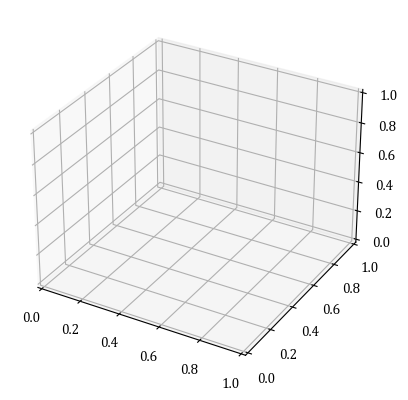

In [153]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
xpos,ypos = np.meshgrid(np.arange(12)+1, np.arange(15)+1)
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

dx = dy = 0.8*np.ones_like(zpos)
dz = np.abs(fittedHW.values).ravel()
#newstuff
cmap = plt.cm.rainbow(plt.Normalize(0,0.4)(dz))

#ax.invert_xaxis()
#ax.invert_yaxis()
#ax.view_init(30, 225)
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=cmap, alpha = 1, edgecolor = 'black')

ax.set_xticks([1.75, 4.75, 7.75, 10.75, 12.75])
ax.set_xticklabels([1, 4, 10, 20, 30])
ax.set_yticks([1.75, 4.75, 7.75, 10.75, 13.75, 15.75])
ax.set_yticklabels([1, 4, 7, 10, 20, 30])


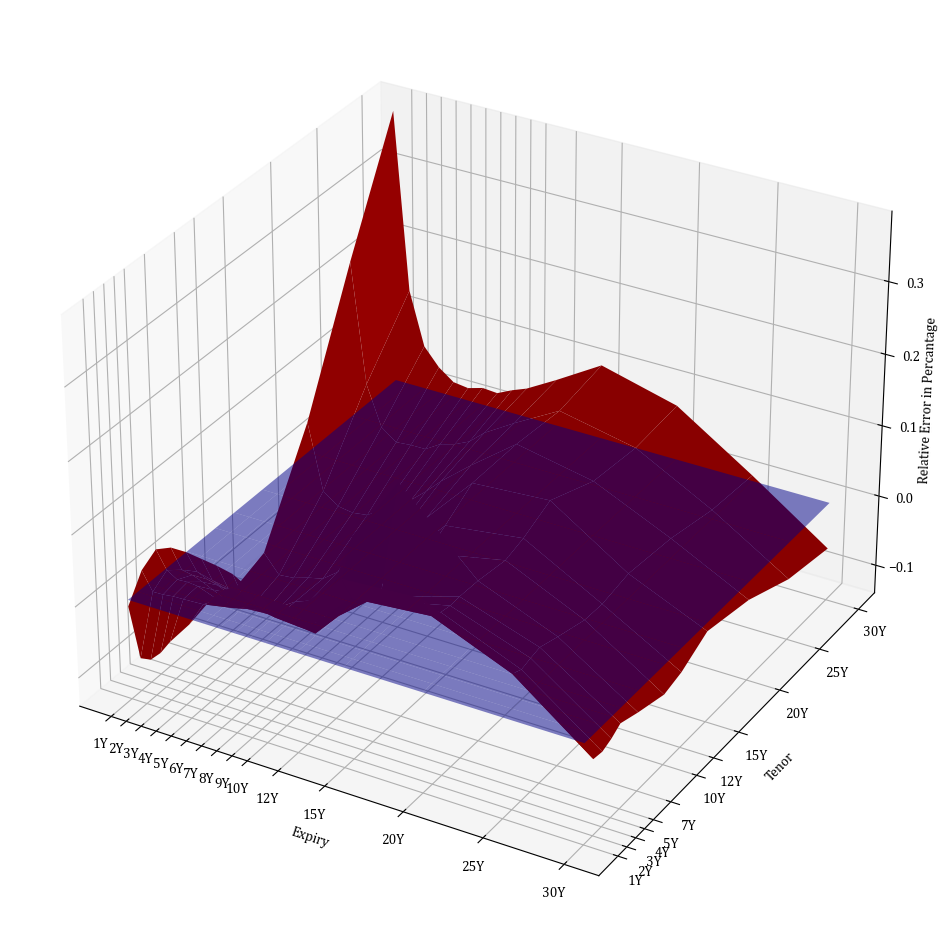

In [7]:
rev=0.08670264780833303#result.x[0]
vol=0.013928489964789946#result.x[1]
fittedHW = (HullWhiteOptimizer(reversion=rev ,volatility=vol, observedP=straddlesobs, observedK=strikes)[1]/straddlesobs-1)
X,Y = np.meshgrid(fittedHW.columns/12, fittedHW.index/12)
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Y,X,np.zeros(15*12).reshape(fittedHW.values.shape), color='blue', alpha=0.5)
ax.plot_surface(Y,X,fittedHW.values, color = 'red')
ax.set_xlabel('Expiry')
ax.set_xticks((straddlesobs.index/12))
ax.set_xticklabels([monthoryear(x) for x in straddlesobs.index])
ax.set_ylabel('Tenor')
ax.set_yticks(straddlesobs.columns/12)
ax.set_yticklabels([f'{int(x/12)}Y' for x in straddlesobs.columns])
ax.zaxis.labelpad=-0.7
ax.set_zlabel('Relative Error in Percantage')
plt.show()
# HullWhiteOptimizer(reversion=rev ,volatility=vol, observedP=straddlesobs, observedK=strikes)[0]

In [23]:
def HullWhiteOptimizerOne(rev, volatility,expiry, tenor, observedP, observedK):
    if volatility <= 0:
        print('Volatility is negative             ',end='\r')
        return 100000
    straddleModel = observedP.copy()
    optHW = HullWhite(initial=0.02748672, 
                      reversion=rev,
                      b = np.array([1.879892, 0.579211, 	3.993992, 1.445091]),
                      tau  = np.array([ 16.633491, 	0.319680]),
                      volatility=volatility)

    # Creating tenor legs
    T = np.arange(expiry/12, expiry/12+tenor/12+0.5, 0.5)
    S = np.arange(expiry/12, expiry/12+tenor/12+1)
    # Finding the ATM fixed rate
    K = observedK[tenor].loc[expiry]/100
    # K = fsolve(lambda x: optHW.swap(0, S, T, x), x0=MarketATM)[0]

    #Calculating the payer and receiver swpt price
    p = optHW.swaption(0,Te=expiry/12, S=S,T=T, K=K, payer=True)
    r = optHW.swaption(0,Te=expiry/12, S=S, T=T, K=K, payer=False)
    
    #Normalizing w.r.t. to the A(t,S) function (2.10) everythin you wanna know...
    A = np.array([optHW.marketZCB(Si) for Si in S[1::]]).sum()

    straddle = (p+r)/A
    # if (p+r)*10000<0:
    # print(p,r,expiry,tenor,reversion,volatility)
            

    error = abs((straddle/observedP[tenor].loc[expiry]-1))
    # print(f'{error}', end='                                                         \r')
    return error

In [24]:
impVolHW = impliedVol.copy()
impRevHW = impliedVol.copy()
errors = impliedVol.copy()

for tenor in impVolHW.columns:
    for expiry in impVolHW.index:
        print(f'\nExpiry: {expiry}, Tenor: {tenor}                     ', end='\r')
        res = minimize(
            lambda x: HullWhiteOptimizerOne(x[0], x[1], expiry, tenor, observedP=straddlesobs, observedK=strikes),
            x0=[result.x[0], result.x[1]],
        )
        impRevHW[tenor].loc[expiry] = res.x[0]
        impVolHW[tenor].loc[expiry] = res.x[1]
        errors[tenor].loc[expiry] = HullWhiteOptimizerOne(res.x[0],res.x[1], expiry, tenor, observedP=straddlesobs, observedK=strikes)


Expiry: 12, Tenor: 12                     
Volatility is negative                    
Volatility is negative                    
Volatility is negative                    
Volatility is negative                    
Volatility is negative                    
Volatility is negative                    
Volatility is negative                    
Volatility is negative                     
Volatility is negative                     
Volatility is negative                     
Volatility is negative                     
Volatility is negative                     
Volatility is negative                     
Expiry: 360, Tenor: 12                     
Expiry: 12, Tenor: 24                     
Volatility is negative                    
Volatility is negative                    
Volatility is negative                    
Volatility is negative                    
Volatility is negative                    
Volatility is negative                    
Volatility is negative                    
Vol

c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)



Volatility is negative                     
Volatility is negative                     
Volatility is negative                     
Volatility is negative                     


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2



Expiry: 12, Tenor: 120                     
Expiry: 24, Tenor: 120                     


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: overflow encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)



Volatility is negative                      
Volatility is negative                      
Volatility is negative                      


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2



Expiry: 12, Tenor: 144                     
Expiry: 24, Tenor: 144                     


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: overflow encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: overflow encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)



Volatility is negative                      
Volatility is negative                      
Volatility is negative                      
Volatility is negative                      


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2



Expiry: 12, Tenor: 180                     


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: overflow encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: overflow encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: overflow encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: overflow encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2



Volatility is negative                      
Volatility is negative                      
Volatility is negative                      
Volatility is negative                      


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2



Volatility is negative                     


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: overflow encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: overflow encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: overflow encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2



Volatility is negative                      
Volatility is negative                      
Volatility is negative                      
Volatility is negative                      
Volatility is negative                      


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2



Volatility is negative                     
Volatility is negative                     


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)



Volatility is negative                     
Volatility is negative                      
Volatility is negative                      
Volatility is negative                      
Volatility is negative                      
Volatility is negative                      
Volatility is negative                      


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: overflow encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2
c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2



Volatility is negative                     
Volatility is negative                     
Volatility is negative                     
Volatility is negative                     
Volatility is negative                     
Volatility is negative                     
Volatility is negative                     
Volatility is negative                     
Volatility is negative                      
Volatility is negative                      
Volatility is negative                      
Volatility is negative                      
Volatility is negative                      
Volatility is negative                      


c:\Users\Shark\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\Shark\OneDrive\Desktop\MasterThesis\HullWhite.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  h      = np.log(self.ZCB(t,S,initRate)/(self.ZCB(t,T,initRate)*X))/sigmap+sigmap/2


[Text(1.0, 0, '1Y'),
 Text(2.0, 0, '2Y'),
 Text(3.0, 0, '3Y'),
 Text(4.0, 0, '4Y'),
 Text(5.0, 0, '5Y'),
 Text(7.0, 0, '7Y'),
 Text(10.0, 0, '10Y'),
 Text(12.0, 0, '12Y'),
 Text(15.0, 0, '15Y'),
 Text(20.0, 0, '20Y'),
 Text(25.0, 0, '25Y'),
 Text(30.0, 0, '30Y')]

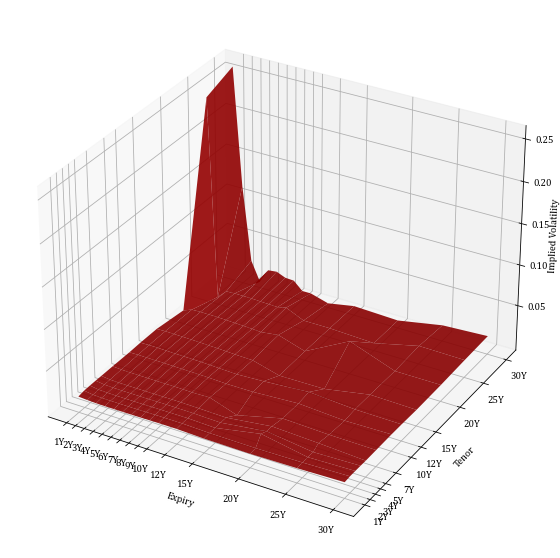

In [25]:
fig = plt.figure(figsize=(10,10))
X,Y = np.meshgrid(impVolHW.columns/12, impliedVol.index/12)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Y,X,impVolHW.values, alpha=0.9, color='red')
ax.set_xlabel('Expiry')
ax.set_xticks((straddlesobs.index/12))
ax.set_xticklabels([monthoryear(x) for x in straddlesobs.index])
ax.set_ylabel('Tenor')
ax.set_zlabel('Implied Volatility')
ax.zaxis.labelpad=-0.7
ax.set_yticks(straddlesobs.columns/12)
ax.set_yticklabels([f'{int(x/12)}Y' for x in straddlesobs.columns])

[Text(1.0, 0, '1Y'),
 Text(2.0, 0, '2Y'),
 Text(3.0, 0, '3Y'),
 Text(4.0, 0, '4Y'),
 Text(5.0, 0, '5Y'),
 Text(7.0, 0, '7Y'),
 Text(10.0, 0, '10Y'),
 Text(12.0, 0, '12Y'),
 Text(15.0, 0, '15Y'),
 Text(20.0, 0, '20Y'),
 Text(25.0, 0, '25Y'),
 Text(30.0, 0, '30Y')]

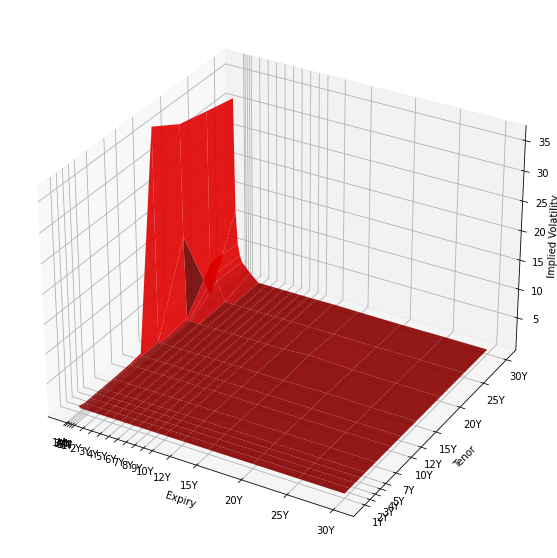

In [44]:
fig = plt.figure(figsize=(10,10))
X,Y = np.meshgrid(impVolHW.columns/12, impliedVol.index/12)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Y,X,impRevHW.values, alpha=0.9, color='red')
ax.set_xlabel('Expiry')
ax.set_xticks((straddlesobs.index/12))
ax.set_xticklabels([monthoryear(x) for x in straddlesobs.index])
ax.set_ylabel('Tenor')
ax.set_zlabel('Implied Volatility')
ax.zaxis.labelpad=-0.7
ax.set_yticks(straddlesobs.columns/12)
ax.set_yticklabels([f'{int(x/12)}Y' for x in straddlesobs.columns])

[Text(1.0, 0, '1Y'),
 Text(2.0, 0, '2Y'),
 Text(3.0, 0, '3Y'),
 Text(4.0, 0, '4Y'),
 Text(5.0, 0, '5Y'),
 Text(7.0, 0, '7Y'),
 Text(10.0, 0, '10Y'),
 Text(12.0, 0, '12Y'),
 Text(15.0, 0, '15Y'),
 Text(20.0, 0, '20Y'),
 Text(25.0, 0, '25Y'),
 Text(30.0, 0, '30Y')]

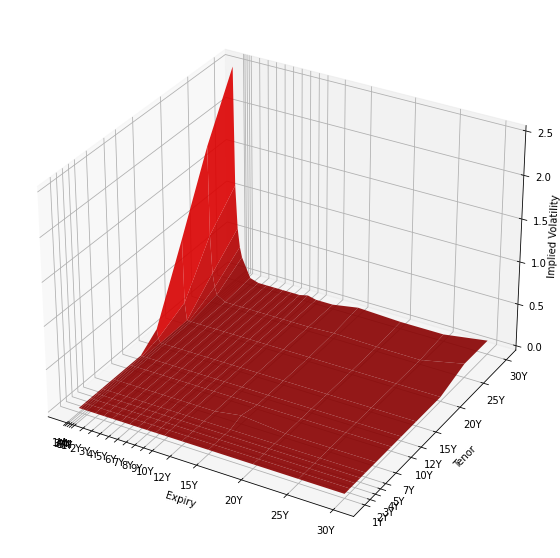

In [45]:
fig = plt.figure(figsize=(10,10))
X,Y = np.meshgrid(impVolHW.columns/12, impliedVol.index/12)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Y,X,errors.values, alpha=0.9, color='red')
ax.set_xlabel('Expiry')
ax.set_xticks((straddlesobs.index/12))
ax.set_xticklabels([monthoryear(x) for x in straddlesobs.index])
ax.set_ylabel('Tenor')
ax.set_zlabel('Implied Volatility')
ax.zaxis.labelpad=-0.7
ax.set_yticks(straddlesobs.columns/12)
ax.set_yticklabels([f'{int(x/12)}Y' for x in straddlesobs.columns])

<AxesSubplot: >

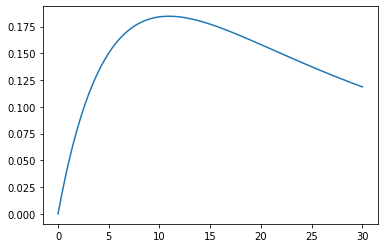

In [39]:
time, float = HW.create_path(1/12, 30, 0)
HW = HullWhite(initial=0.02748672, 
                      reversion=0.13, 
                      kappa=0.1001, 
                      b = np.array([1.879892, 0.579211, 	3.993992, 1.445091]),
                      tau  = np.array([ 16.633491, 	0.319680]),
                      volatility=0.05)
sns.lineplot(x=time, y=[HW.marketZCB(t)-HW.ZCB(0,t) for t in time])
# sns.lineplot(x=time, y=[HW.ZCB(0,t) for t in time])

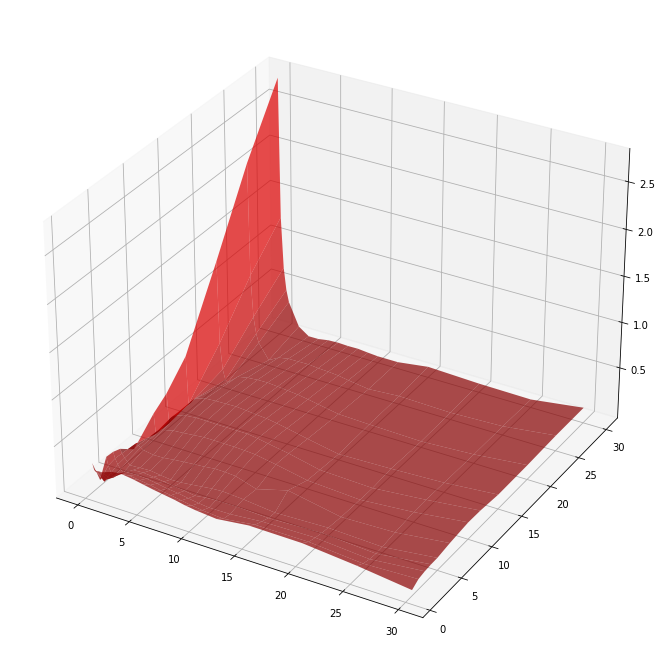

In [51]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(111, projection='3d')

X,Y = np.meshgrid(straddlesobs.columns/12, straddlesobs.index/12)
ax1.plot_surface(Y,X,straddlesobs.values, alpha=0.7, color='blue')

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Y,X,fittedHW.values, alpha=0.7, color='red')



ax1.set_xlabel('Expiry')
ax1.set_xticks((straddlesobs.index/12)[::-1])
ax1.set_ylabel('Tenor')
ax1.set_yticks(straddlesobs.columns/12)
ax1.invert_xaxis()

# ax1 = fig.add_subplot(111, projection='3d')


plt.show()

<AxesSubplot: >

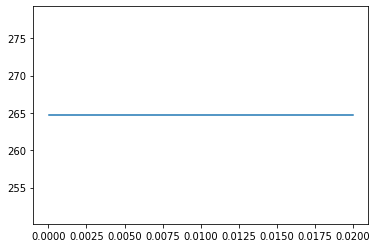

In [99]:
sns.lineplot(x=np.linspace(0.00001,0.02,10), y=[HullWhiteOptimizer(reversion=0.88 ,volatility=vol, observedP=straddlesobs, observedK=strikes)[0] for vol in np.linspace(0.00001,0.02,10)])